In [17]:
#Declare class

import tensorflow as tf
from tensorflow.keras import layers as L 
from functools import reduce

import numpy as np

class ResidualDense(tf.keras.Model):
    def __init__(self, units, use_bn=True, activation=tf.nn.elu, **kwargs):
        super().__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.d1 = tf.keras.layers.Dense(units, **kwargs)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.d2 = tf.keras.layers.Dense(units, **kwargs)
        self.activation = activation
    
    def call(self, x):
        y = self.activation(self.d1(self.bn1(x)))
        y = self.activation(self.d2(self.bn2(y)))
        return y + x


class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, n_layers=40, **kwargs):
        super().__init__()
        self.d0 = tf.keras.layers.Dense(output_dim, activation=tf.nn.elu, **kwargs)
        self.dense_layers = [
            ResidualDense(output_dim, **kwargs) for i in range(n_layers)
        ]
        self. d1 = tf.keras.layers.Dense(output_dim, activation=None)

    def call(self, x):
        assert_all_finite(self.d0, x)
        y0 = self.d0(x)
        assert_all_finite(self.d0, x)
        for layer in self.dense_layers:
            y0 = layer(y0)
            assert_all_finite(layer, y0)
        y = self.d1(y0)
        assert_all_finite(self.d1, y)
        return y

last_error_input = None
def assert_all_finite(layer, x):
    global last_error_input
    last_error_input =(layer, x)
    if isinstance(layer, ResidualDense):
        assert_all_finite(layer.d1, x)
        assert_all_finite(layer.d2, x)
        return
    elif issubclass(type(layer), tf.keras.layers.Layer):
        message = f"Invalid value appear: {layer.name}\n"
        for var in layer.trainable_variables:
            tf.debugging.assert_all_finite(var, message)
        for var in layer.non_trainable_variables:
            tf.debugging.assert_all_finite(var, message)
        tf.debugging.assert_all_finite(x, message)
        
        
class VAE(tf.keras.Model):
    def __init__(
        self, dim_list,
    ):
        super().__init__()
        self.latent_dim = dim_list[-1]
        self.inference_net = self.create_regressor(*dim_list)
        self.generative_net = self.create_regressor(*dim_list[::-1])

    def create_regressor(self, *dims):
        dense_list = []
        for i, dim in enumerate(dims):
            if i == (len(dims) - 1):
                activation = None
            else:
                activation = tf.nn.elu
            dense_list.extend([tf.keras.layers.Dense(dim, activation=activation)])
        return tf.keras.Sequential(dense_list)
        
    def call(self, x):
        self.latent = self.inference_net(x)
        mean, logvar = tf.split(self.latent, 2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits
    
class ResidualVAE(VAE):
    def __init__(
        self, dim_list, n_residuals=4,
    ):
        self.n_residuals = n_residuals
        super().__init__(dim_list)

    def create_regressor(self, *dims):
        dense_list = []
        for i, dim in enumerate(dims[:-1]):
            dense_list.extend([
                tf.keras.layers.Dense(dim, activation=tf.keras.activations.elu),
            ] + [
                ResidualDense(dim)
                for i in range(self.n_residuals)
            ])
        dense_list.append(
            tf.keras.layers.Dense(dims[-1], activation=None)
        )
        return tf.keras.Sequential(dense_list)
        
net = ResidualVAE([128, 96, 64, 32])
output = net(tf.random.uniform((4, 128)))
net.summary()
print(output.shape)

Model: "residual_vae_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    multiple                  286272    
_________________________________________________________________
sequential_9 (Sequential)    multiple                  143680    
Total params: 429,952
Trainable params: 422,272
Non-trainable params: 7,680
_________________________________________________________________
(4, 128)


In [24]:
# Load breast cancer dataset
from sklearn.datasets import load_wine, load_digits
from sklearn.model_selection import train_test_split

data = load_breast_cancer()

import pandas as pd
xs = pd.DataFrame(data.data, columns=data.feature_names)
ys = data.target

mu_std = {}
for col in xs.columns:
    mu = xs[col].mean()
    std = xs[col].std()
    xs[col] = (xs[col] - mu) / std
    mu_std[col] = (mu, std)

train_indices, test_indices = train_test_split(range(len(xs)))
train_xs = xs.iloc[train_indices]
test_xs = xs.iloc[test_indices]

TRAIN_BUF = 1000
BATCH_SIZE = 32
TEST_BUF = 1000
n_input_dim = train_xs.shape[1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_xs.astype(np.float32)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_xs.astype(np.float32)).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [3]:
# Load digits.
from sklearn.datasets import load_wine, load_digits
from sklearn.model_selection import train_test_split

digits, labels = load_digits(return_X_y=True)
digits = (digits > 0).astype(np.float32)

import pandas as pd
train_indices, test_indices = train_test_split(range(len(digits)))
train_xs = digits[train_indices]
test_xs = digits[test_indices]

TRAIN_BUF = 1000
BATCH_SIZE = 32
TEST_BUF = 1000
n_input_dim = train_xs.shape[1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_xs.astype(np.float32)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_xs.astype(np.float32)).shuffle(TEST_BUF).batch(BATCH_SIZE)

<IPython.core.display.Javascript object>


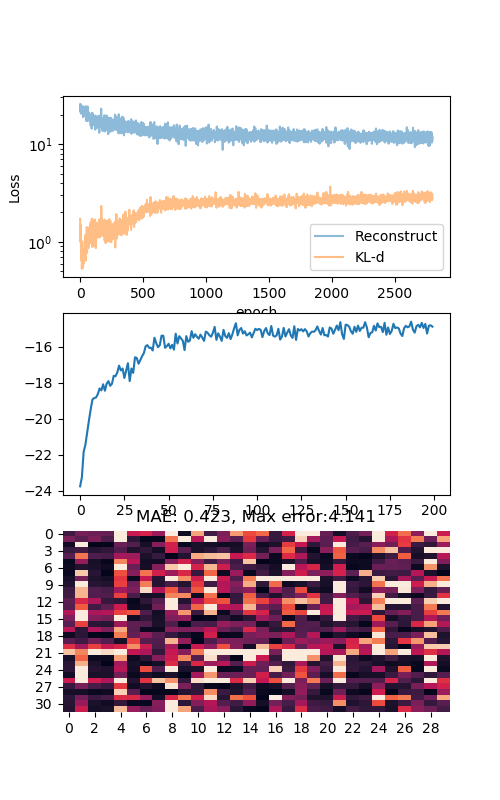

In [30]:
from IPython import display
from collections import defaultdict 
from itertools import product
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time
import seaborn as sns

#%matplotlib widget
%matplotlib notebook


epochs = 200
latent_dim = 8
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
#model = ResidualVAE([n_input_dim, 8, 4])
model = VAE([n_input_dim, 16, 12, latent_dim])
optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.99)

def gaussian_kl_divergence(mean, ln_var, raxis=1):
    var = tf.exp(ln_var)
    mean_square = mean * mean
    return tf.reduce_sum((mean_square + var - ln_var - 1) * 0.5, axis=raxis)


#@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    reconst_x = model.decode(z)

    absolute_error = tf.abs(reconst_x - x)
    loss_reconst = tf.reduce_sum(absolute_error, axis=1)
    loss_kld = gaussian_kl_divergence(mean, logvar)

    return {
        'loss': {
            'Reconstruct': tf.reduce_mean(loss_reconst),
            'KL-d': tf.reduce_mean(loss_kld),
        },
        'raw': {
            'AE': absolute_error, 
            'Original': x,
            'Reconstruct': reconst_x,
        }
    }

#@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        losses = compute_loss(model, x)
        loss = sum(losses['loss'].values())
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return losses

fig, axes = plt.subplots(3, 1, figsize=(5, 8))
plt.ion()

loss_history = defaultdict(list)
elbo_history = []
with tf.device('/GPU:0'):
    for epoch in trange(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            data = compute_apply_gradients(model, train_x, optimizer)
            for name, loss in data['loss'].items():
                loss_history[name].append(loss.numpy())
        end_time = time.time()

        if epoch % 1 == 0:
            loss = tf.keras.metrics.Mean()
            raw = None
            for test_x in test_dataset:
                losses = compute_loss(model, test_x)
                if raw is None:
                    raw = losses['raw']
                loss(sum(losses['loss'].values()))
            elbo = -loss.result()
            elbo_history.append(elbo)

            loss_ax = axes.flat[0]
            loss_ax.clear()
            for name, loss in loss_history.items():
                loss_ax.plot(loss, label=name, alpha=0.5)
            loss_ax.set_xlabel('epoch')
            loss_ax.set_ylabel('Loss')
            loss_ax.set_yscale('log')
            loss_ax.legend()

            elbo_ax = axes.flat[1]
            elbo_ax.clear()
            elbo_ax.plot(elbo_history)

            data_ax = axes.flat[2]
            data_ax.clear()
            absolute_error = raw['AE'].numpy()
            if np.any(np.isnan(absolute_error)):
                tqdm.write('The output is nan.')
            absolute_error[np.isnan(absolute_error)] = 0.0

            sns.heatmap(absolute_error, ax=data_ax, cbar=False, vmin=0.0, vmax=1.0)
            data_ax.set_title(f'MAE: {np.mean(absolute_error):.3f}, Max error:{np.amax(absolute_error):.3f}')
            fig.canvas.draw()
            

In [ ]:
import pickle
import tqdm